In [101]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
import seaborn as sns
import tensorflow as tf
from tensorflow import keras as ks
import warnings
warnings.filterwarnings('ignore')

In [102]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [135]:
path ='/content/drive/MyDrive/d2.csv'
data = pd.read_csv(path)


In [136]:
x = data[['T','RH','AH']]
x = x.iloc[:7674,:]
x = np.array(x)
y = data['CO(GT)']
y = y.iloc[:7674]

In [137]:
x.shape, y.shape

((7674, 3), (7674,))

In [138]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y)
print(x_train.shape)

(5755, 3)


In [139]:
from sklearn.svm import SVR
support_vector_reg = SVR(kernel='rbf', C=100, gamma=0.01, epsilon=.1)
support_vector_reg.fit(x_train,y_train)
y_pred = support_vector_reg.predict(x_test)
y_pred

array([1.73323904, 1.70699896, 2.78868502, ..., 1.70353277, 2.1384605 ,
       2.19984928])

In [140]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

In [141]:
MSEScore = mean_squared_error(y_test, y_pred)
print(f"mean squared_error metric: {MSEScore}")
r2Score = r2_score(y_test, y_pred)
print(f"r^2 metric: {r2Score}")
rmsScore = mean_squared_error(y_test, y_pred, squared=False)
print(f"root mean squared_error metric: {rmsScore}")
MAEScore = mean_absolute_error(y_test, y_pred)
print(f"mean absolute error metric: {MAEScore}")

mean squared_error metric: 2.077919581960003
r^2 metric: -0.011689893674314833
root mean squared_error metric: 1.4414990745609249
mean absolute error metric: 1.0305837211885853


CPU times: user 9min 59s, sys: 4.33 s, total: 10min 3s
Wall time: 10min 4s


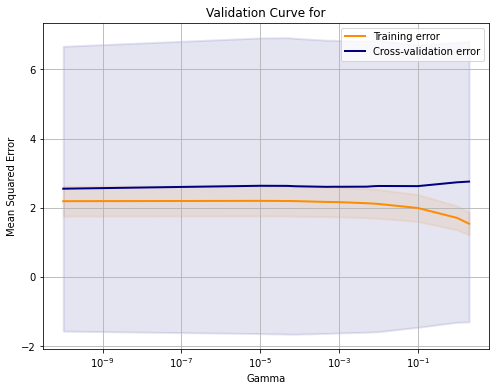

In [153]:
%%time
from sklearn.model_selection import validation_curve
gamma_list = [0.0000000001,0.00001,0.00005,0.000075,0.0001,0.0005,0.00075,0.001,0.005,0.0075,0.01,0.1,1,2]
train_scores, test_scores = validation_curve(SVR(), x, y, 
                                              param_name="gamma",
                                              param_range=gamma_list , cv=10, 
                                              scoring = 'neg_mean_squared_error',
                                              n_jobs=1)
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.grid()
plt.title("Validation Curve for")
plt.xlabel(r"Gamma")
plt.ylabel("Mean Squared Error")

lw = 2
plt.semilogx(gamma_list, train_scores_mean, label="Training error",
             color="darkorange", lw=lw)
plt.fill_between(gamma_list, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="darkorange", lw=lw)
plt.semilogx(gamma_list, test_scores_mean, label="Cross-validation error",
             color="navy", lw=lw)
plt.fill_between(gamma_list, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.savefig('SVR_validation curve.jpg',dpi=500)

In [154]:
from sklearn.model_selection import GridSearchCV
gamma_list = [0.0000000001,0.00001,0.00005,0.000075,0.0001,0.0005,0.00075,0.001,0.005,0.0075,0.01,1,2]
params = {'gamma':gamma_list}
svr = SVR()
svr_gs = GridSearchCV(svr, param_grid=params, n_jobs=1, cv=10, scoring='neg_mean_squared_error')
svr_gs.fit(x_train, y_train)
print("Best Gamma found on development set:")
print()
print( svr_gs.best_params_ )

Best Gamma found on development set:

{'gamma': 0.01}


In [155]:
gridsearch_SVR = pd.DataFrame(svr_gs.cv_results_)
gridsearch_SVR

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1.478904,0.011673,0.068908,0.001196,1e-10,{'gamma': 1e-10},-2.570086,-2.605684,-2.169571,-2.494722,-2.392808,-1.964971,-2.314510,-2.397639,-1.799956,-1.874577,-2.258452,0.276710,11
1,1.652291,0.002662,0.070398,0.002138,1e-05,{'gamma': 1e-05},-2.556591,-2.569052,-2.170801,-2.492490,-2.372299,-1.971308,-2.307957,-2.374236,-1.783796,-1.853144,-2.245167,0.273294,10
2,1.660258,0.006484,0.070691,0.002663,5e-05,{'gamma': 5e-05},-2.556701,-2.559990,-2.173258,-2.488276,-2.375101,-1.970201,-2.307839,-2.374976,-1.782455,-1.847142,-2.243594,0.273168,9
3,1.666745,0.006956,0.072648,0.003974,7.5e-05,{'gamma': 7.5e-05},-2.554237,-2.556216,-2.172949,-2.487647,-2.375095,-1.969630,-2.304130,-2.376113,-1.780077,-1.844059,-2.242015,0.273278,8
4,1.677849,0.021078,0.070434,0.001462,0.0001,{'gamma': 0.0001},-2.550223,-2.552535,-2.168986,-2.479113,-2.375844,-1.966733,-2.301448,-2.373219,-1.775267,-1.840100,-2.238347,0.273250,7
5,1.688691,0.004976,0.071762,0.002270,0.0005,{'gamma': 0.0005},-2.542231,-2.520978,-2.129584,-2.460637,-2.360125,-1.947198,-2.270138,-2.339209,-1.765564,-1.822044,-2.215771,0.271290,6
6,1.719771,0.009344,0.070485,0.002189,0.00075,{'gamma': 0.00075},-2.542418,-2.519566,-2.122415,-2.450970,-2.362689,-1.940775,-2.264688,-2.328419,-1.763351,-1.817787,-2.211308,0.271696,5
7,1.694109,0.011772,0.070012,0.001003,0.001,{'gamma': 0.001},-2.539460,-2.517185,-2.117269,-2.449131,-2.364844,-1.938864,-2.263317,-2.329810,-1.761574,-1.815240,-2.209669,0.272084,4
8,1.817995,0.010410,0.084305,0.002314,0.005,{'gamma': 0.005},-2.526937,-2.523310,-2.103614,-2.422181,-2.332332,-1.917368,-2.271306,-2.292608,-1.734213,-1.817627,-2.194150,0.272754,3
9,1.728544,0.014982,0.071381,0.002106,0.0075,{'gamma': 0.0075},-2.520027,-2.524100,-2.110754,-2.408745,-2.323228,-1.905995,-2.264928,-2.279175,-1.722174,-1.814258,-2.187338,0.273243,2


In [156]:
def plot_learning_curve(estimator, X, y, axes=None, ylim=None, cv=None,n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(30,10))

    axes[0].set_title("Learning Curve")
    
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Mean Squared Error")


    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       scoring = 'neg_mean_squared_error',
                       return_times=True)
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training error")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation error")
    axes[0].legend(loc="best")


    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit times (s)")
    axes[1].set_title("Scalability of the model")


    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit times (s)")
    axes[2].set_ylabel("Mean Squared Error")
    axes[2].set_title("Performance of the model")


    return plt

CPU times: user 11min 12s, sys: 4.58 s, total: 11min 17s
Wall time: 11min 18s


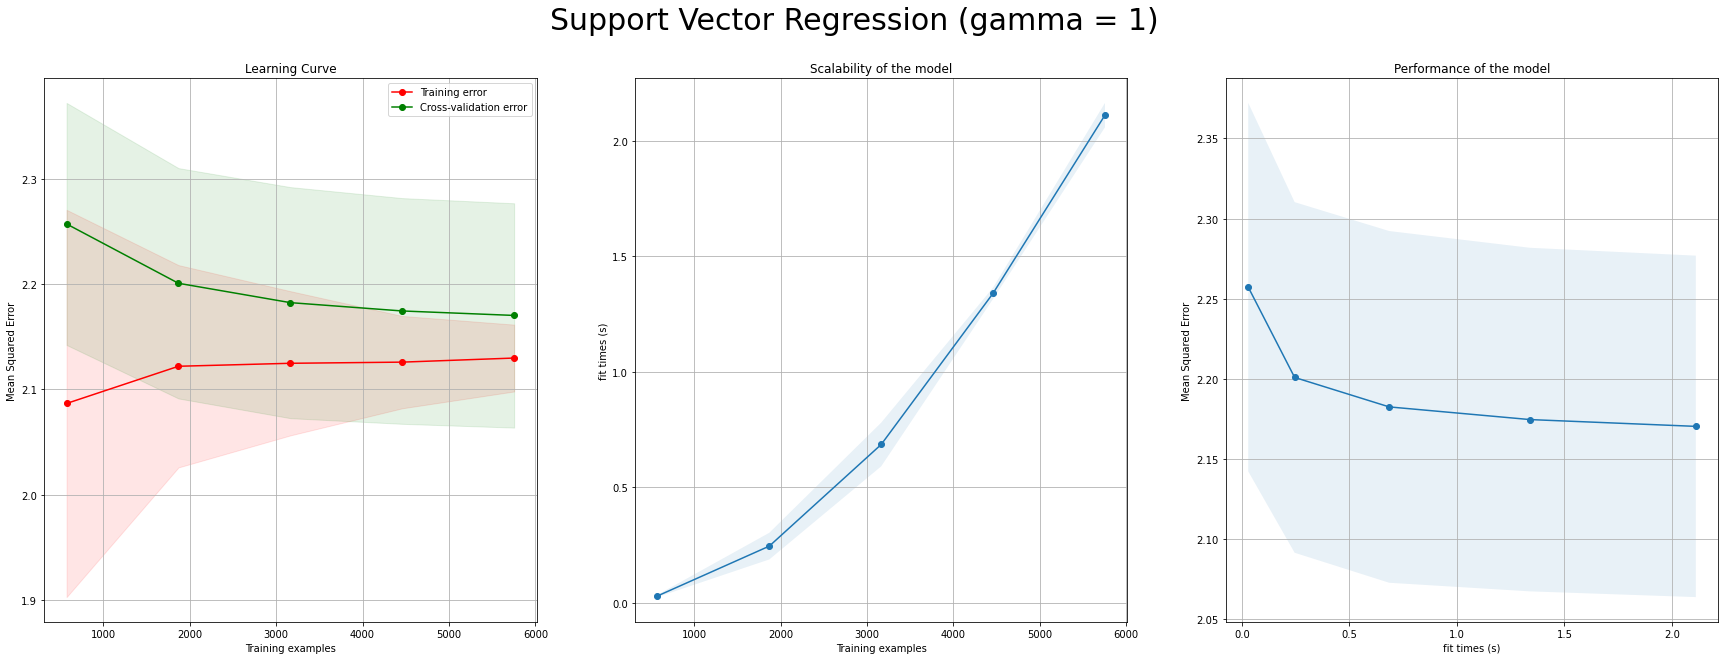

In [157]:
%%time
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 25% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.25, random_state=0)

estimator = SVR(gamma=0.01)
plot_learning_curve(estimator, X = x , y=y ,cv=cv)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rc('axes',labelsize=20)
plt.rc('axes',titlesize=20)
plt.rc('legend',fontsize=15)
plt.suptitle(r"Support Vector Regression (gamma = 1)",fontsize=30)
plt.savefig('svr_learning_curves.jpg',dpi=500)

Final fitting with best hyperparameters

In [158]:
svr= SVR(kernel='rbf', C=100, gamma=0.01, epsilon=.1)

In [159]:
%%time
svr.fit(x_train,y_train)

CPU times: user 5.14 s, sys: 21.4 ms, total: 5.16 s
Wall time: 5.8 s


SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [160]:
%%time
y_pred_svr = svr.predict(x_test)

CPU times: user 262 ms, sys: 0 ns, total: 262 ms
Wall time: 264 ms


In [161]:
MSEScore = mean_squared_error(y_test,y_pred_svr)
print(f"mean squared error metric: {MSEScore}")
print()
##
r2Score = r2_score(y_test,y_pred_svr)
print(f"r^2 metric: {r2Score}")
print()
##
rmsScore = mean_squared_error(y_test, y_pred_svr, squared=False)
print(f"root mean squared_error metric: {rmsScore}")
print()
##
MAEScore = mean_absolute_error(y_test, y_pred_svr)
print(f"mean absolute error metric: {MAEScore}")

mean squared error metric: 2.077919581960003

r^2 metric: -0.011689893674314833

root mean squared_error metric: 1.4414990745609249

mean absolute error metric: 1.0305837211885853


FNN

In [167]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
import seaborn as sns
import tensorflow as tf
from tensorflow import keras as ks
import warnings
warnings.filterwarnings('ignore')

In [168]:
from tensorflow import keras as ks

model = ks.Sequential()
model.add(ks.layers.Dense(20, activation=ks.activations.tanh, input_dim = 3))
model.add(ks.layers.Dense(20, activation=ks.activations.relu))
model.add(ks.layers.Dense(20, activation=ks.activations.softsign))
model.add(ks.layers.Dense(209, activation=ks.activations.softmax))
model.add(ks.layers.Dense(211, activation=ks.activations.tanh))
model.add(ks.layers.Dense(20, activation=ks.activations.tanh))
model.add(ks.layers.Dense(20, activation=ks.activations.tanh))
model.add(ks.layers.Dense(1, activation=ks.activations.linear))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 20)                80        
_________________________________________________________________
dense_69 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_70 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_71 (Dense)             (None, 209)               4389      
_________________________________________________________________
dense_72 (Dense)             (None, 211)               44310     
_________________________________________________________________
dense_73 (Dense)             (None, 20)                4240      
_________________________________________________________________
dense_74 (Dense)             (None, 20)               

In [173]:
model.compile( loss='mean_absolute_error',optimizer='Adam',metrics='mae')

In [174]:
history = model.fit(x_train, y_train, epochs=300, batch_size=50,  verbose=1, validation_split=0.2)

Epoch 1/300
93/93 [==============================] - 2s 9ms/step - loss: 1.2340 - mae: 1.2340 - val_loss: 1.0082 - val_mae: 1.0082
Epoch 2/300
93/93 [==============================] - 0s 4ms/step - loss: 1.1173 - mae: 1.1173 - val_loss: 1.0067 - val_mae: 1.0067
Epoch 3/300
93/93 [==============================] - 0s 4ms/step - loss: 1.1189 - mae: 1.1189 - val_loss: 1.0043 - val_mae: 1.0043
Epoch 4/300
93/93 [==============================] - 0s 3ms/step - loss: 1.1156 - mae: 1.1156 - val_loss: 0.9996 - val_mae: 0.9996
Epoch 5/300
93/93 [==============================] - 0s 3ms/step - loss: 1.1159 - mae: 1.1159 - val_loss: 0.9984 - val_mae: 0.9984
Epoch 6/300
93/93 [==============================] - 0s 3ms/step - loss: 1.1130 - mae: 1.1130 - val_loss: 1.0164 - val_mae: 1.0164
Epoch 7/300
93/93 [==============================] - 0s 3ms/step - loss: 1.1128 - mae: 1.1128 - val_loss: 0.9985 - val_mae: 0.9985
Epoch 8/300
93/93 [==============================] - 0s 4ms/step - loss: 1.1129 - m

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


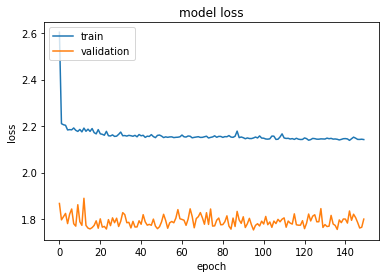

In [147]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [175]:
y_pred = model.predict(x_test)

In [176]:
!pip install -q -U keras-tuner
import kerastuner as kt

     |████████████████████████████████| 102kB 2.0MB/s 


In [183]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

def model_fnn(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 10)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=20,
                                            max_value=210,
                                            step=10),
                               activation=hp.Choice('act_'+ str(i), ['relu','softmax','tanh'])))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',values = [0.1,0.001,0.0001])),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error'])
    return model

In [184]:
tuner = RandomSearch(
    model_fnn,
    objective='val_mean_absolute_error',
    max_trials=5,
    executions_per_trial=3,
    directory='new_project')

INFO:tensorflow:Reloading Oracle from existing project new_project/untitled_project/oracle.json


In [186]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 210, 'step': 10, 'sampling': None}
act_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'softmax', 'tanh'], 'ordered': False}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 210, 'step': 10, 'sampling': None}
act_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'softmax', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.001, 0.0001], 'ordered': True}


In [ ]:
tuner.search(x_train, y_train,
             epochs=300,
             batch_size = 30,
             validation_data=(x_test, y_test))

Trial 2 Complete [00h 12m 10s]
val_mean_absolute_error: 1.029467225074768

Best val_mean_absolute_error So Far: 1.029467225074768
Total elapsed time: 00h 22m 11s

Search: Running Trial #3

Hyperparameter    |Value             |Best Value So Far 
num_layers        |8                 |6                 
units_0           |60                |120               
act_0             |softmax           |tanh              
units_1           |170               |140               
act_1             |softmax           |softmax           
learning_rate     |0.1               |0.001             
units_2           |120               |30                
act_2             |relu              |relu              
units_3           |210               |140               
act_3             |relu              |tanh              
units_4           |180               |180               
act_4             |relu              |relu              
units_5           |60                |20                
act_5        

In [ ]:
tuner.results_summary()

In [ ]:
best_model = tuner.get_best_models()[0]

In [ ]:
history = best_model.fit(x_train, y_train, epochs=300, batch_size=30,  verbose=1, validation_split=0.2)

In [ ]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_pred = best_model.predict(x_test)